In [1]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Packages for modelling
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers

Using TensorFlow backend.


# Data Preprocessing

In [2]:
df = joblib.load("../data/df_final_v3.gzip")
df["date"] = pd.to_datetime(df["date"])
df = df[["date", "clean_tweet"]]
df = df.groupby("date")["clean_tweet"].agg(sum)
df.head()

date
2017-01-01    Happy New Year, everyone! Like atUser just tol...
2017-01-03    New Glaeser paper on real estate bubbles sugge...
2017-01-04    China leading financial reformer Peoples Bank ...
2017-01-05    Zhou Xiaochuan: Life for dogs !! - Sign the Pe...
2017-01-06    bis Haruhiko Kuroda: A new phase of the global...
Name: clean_tweet, dtype: object

In [3]:
fx = pd.read_csv("../data/GBPUSD1440.csv", header=None, sep="\t", 
                 names=["Time", "Open", "High", "Low", "Close", "Volume"])
fx.columns = ["date", "Open", "High", "Low", "Close", "Volume"]
fx["date"] = pd.to_datetime(fx["date"])
fx.sort_values(by='date', inplace=True)
fx.reset_index(drop=True, inplace=True)
fx["label"] = fx["Close"].diff(periods=1)
fx.dropna(inplace=True)
fx["label"] = fx["label"].map(lambda x: 1 if float(x)>=0 else 0)
fx.head()

,date,Open,High,Low,Close,Volume,label
1,2007-01-02,1.96330,1.97418,1.96040,1.97295,157568,1
2,2007-01-03,1.97301,1.97490,1.94814,1.95169,147924,0
3,2007-01-04,1.95165,1.95296,1.93980,1.94258,148462,0
4,2007-01-05,1.94251,1.94316,1.92633,1.92900,142467,0
5,2007-01-07,1.93033,1.93057,1.92907,1.92932,6268,1


In [4]:
tweet_and_fx = pd.merge(df, fx, on=["date"])
tweet_and_fx.set_index('date', inplace=True)
print(tweet_and_fx.index.min())
print(tweet_and_fx.index.max())
del df, fx

2017-01-01 00:00:00
2020-06-16 00:00:00


In [5]:
tweet_and_fx = tweet_and_fx[["clean_tweet", "label"]]
tweet_and_fx.columns = ["content", "label"]
tweet_and_fx.head()

,content,label
date,,
2017-01-01,"Happy New Year, everyone! Like atUser just tol...",1
2017-01-03,New Glaeser paper on real estate bubbles sugge...,0
2017-01-04,China leading financial reformer Peoples Bank ...,1
2017-01-05,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,1
2017-01-06,bis Haruhiko Kuroda: A new phase of the global...,0


# Word Embedding

In [6]:
# Hyperparameters setting
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 64
VALIDATION_SPLIT = 0.3
GLOVE_DIR = r"F:\embedding_file"
EMBEDDING_DIM = 100
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 0.1
decay = 0.25

In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(tweet_and_fx.content)
sequences = tokenizer.texts_to_sequences(tweet_and_fx.content)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(tweet_and_fx.label))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
indices = np.arange(data.shape[0])
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:-int(nb_validation_samples/2)]
y_val = labels[-nb_validation_samples:-int(nb_validation_samples/2)]
x_test = x_val[-int(nb_validation_samples/2):]
y_test = y_val[-int(nb_validation_samples/2):]
print("Train size: ", x_train.shape)
print("Valid size: ", x_val.shape)
print("Test size: ", x_test.shape)

Found 194150 unique tokens.
Shape of data tensor: (1038, 64)
Shape of label tensor: (1038, 2)
Train size:  (727, 64)
Valid size:  (156, 64)
Test size:  (155, 64)


In [8]:
def get_embedding_weights(EMBEDDING_DIM=300, GLOVE_DIR=r"F:\embedding_file"):
    if EMBEDDING_DIM == 300:
        embed_file = r"glove.42B.300d.txt"
    elif EMBEDDING_DIM == 100:
        embed_file = r"glove-twitter-27B-100d.txt"
    else: 
        print("Please type in right dimension...")
    
    # Build vocabulary from pre-trained word embedding.
    embeddings_index = {}
    f = open(os.path.join(GLOVE_DIR, embed_file), encoding="utf-8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    
    # Get word vectors.
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [9]:
embedding_matrix = get_embedding_weights(EMBEDDING_DIM=EMBEDDING_DIM)
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Found 1193515 word vectors.


# Modelling

In [10]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
def cnn(MAX_SEQUENCE_LENGTH):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(32, 5, padding="same", activation='relu')(embedded_sequences)
    x = BatchNormalization()(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, 4, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling1D(pool_size=16)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(2, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=learning_rate, decay=decay),
                  metrics=[f1])
    return model

def clstm(MAX_SEQUENCE_LENGTH):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(32, 5, padding="same", activation='relu')(embedded_sequences)
    x = BatchNormalization()(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, 4, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation="relu")(x)
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer="l2"))(x)
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer="l2"))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(2, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=learning_rate, decay=decay),
                  metrics=[f1])
    return model

model = clstm(MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-10)

# Let the rob hit the road!
history = model.fit(
    x_train, y_train, validation_data=(x_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, reduce_lr])

Train on 727 samples, validate on 156 samples
Epoch 1/100
727/727 [==============================] - 4s 5ms/step - loss: 7.3979 - f1: 0.5254 - val_loss: 7.3179 - val_f1: 0.4821
Epoch 2/100
727/727 [==============================] - 1s 1ms/step - loss: 7.2624 - f1: 0.5792 - val_loss: 7.2518 - val_f1: 0.4759
Epoch 3/100
727/727 [==============================] - 1s 1ms/step - loss: 7.2046 - f1: 0.6158 - val_loss: 7.2119 - val_f1: 0.4759
Epoch 4/100
727/727 [==============================] - 1s 1ms/step - loss: 7.1663 - f1: 0.6188 - val_loss: 7.1818 - val_f1: 0.4893
Epoch 5/100
727/727 [==============================] - 1s 1ms/step - loss: 7.1380 - f1: 0.6417 - val_loss: 7.1599 - val_f1: 0.4875
Epoch 6/100
727/727 [==============================] - 1s 1ms/step - loss: 7.1143 - f1: 0.6620 - val_loss: 7.1422 - val_f1: 0.4946
Epoch 7/100
727/727 [==============================] - 1s 1ms/step - loss: 7.0949 - f1: 0.6522 - val_loss: 7.1260 - val_f1: 0.5312
Epoch 8/100
727/727 [================

Epoch 63/100
727/727 [==============================] - 1s 1ms/step - loss: 6.8116 - f1: 0.7403 - val_loss: 6.9071 - val_f1: 0.5071
Epoch 64/100
727/727 [==============================] - 1s 1ms/step - loss: 6.8113 - f1: 0.7422 - val_loss: 6.9057 - val_f1: 0.5009
Epoch 65/100
727/727 [==============================] - 1s 1ms/step - loss: 6.8075 - f1: 0.7476 - val_loss: 6.9042 - val_f1: 0.5009
Epoch 66/100
727/727 [==============================] - 1s 1ms/step - loss: 6.8077 - f1: 0.7276 - val_loss: 6.9029 - val_f1: 0.5009
Epoch 67/100
727/727 [==============================] - 1s 1ms/step - loss: 6.8049 - f1: 0.7354 - val_loss: 6.9016 - val_f1: 0.5009
Epoch 68/100
727/727 [==============================] - 1s 1ms/step - loss: 6.8008 - f1: 0.7408 - val_loss: 6.9002 - val_f1: 0.5009
Epoch 69/100
727/727 [==============================] - 1s 1ms/step - loss: 6.8006 - f1: 0.7460 - val_loss: 6.8989 - val_f1: 0.5009
Epoch 70/100
727/727 [==============================] - 1s 1ms/step - loss: 

In [12]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 100)           19415100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 32)            16032     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 32)            128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            8256

# Performance

In [13]:
def plot_history(history):
    plt.style.use('ggplot')
    # plot results
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1 = history.history['f1']
    val_f1 = history.history['val_f1']

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    epochs = len(loss)
    plt.plot(range(epochs), loss, marker='.', label='loss')
    plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(2, 1, 2)
    plt.title('F1 Score')
    plt.plot(range(epochs), f1, marker='.', label='f1')
    plt.plot(range(epochs), val_f1, marker='.', label='val_f1')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('f1')
    
    plt.tight_layout()
    plt.show()

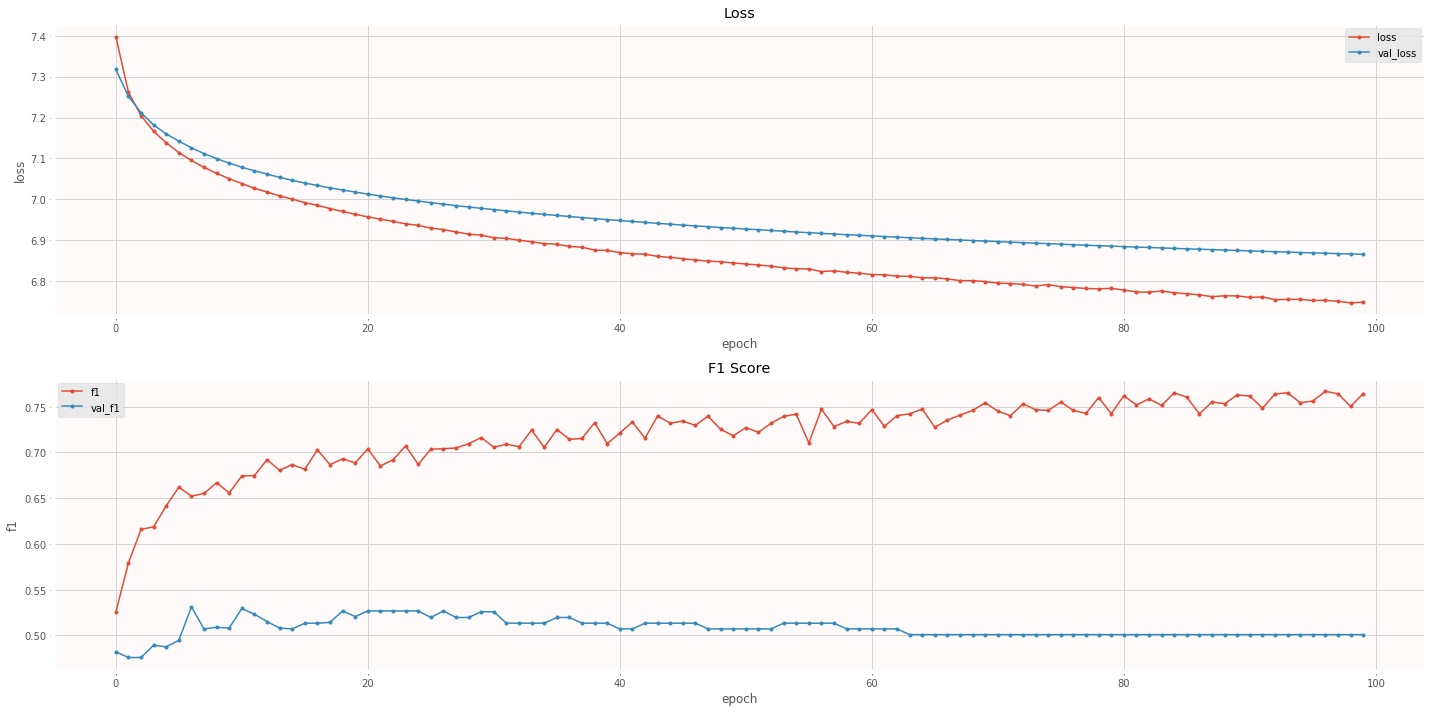

In [14]:
plot_history(history)

In [15]:
y_pred = model.predict(x_test)
pred = np.argmax(y_pred, axis=1)
test = np.argmax(y_test, axis=1)

In [16]:
print(classification_report(test, pred, target_names=["down", "up"], zero_division=0))

              precision    recall  f1-score   support

        down       0.52      0.48      0.50        81
          up       0.47      0.51      0.49        74

    accuracy                           0.50       155
   macro avg       0.50      0.50      0.50       155
weighted avg       0.50      0.50      0.50       155



In [17]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize=(10, 8))
    hmap = sns.heatmap(cm, annot=True, fmt="d", cmap=sns.color_palette("GnBu_d"))
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha="right")
    plt.xlabel("Predicted Movement")
    plt.ylabel("Target Movement")
    plt.show()

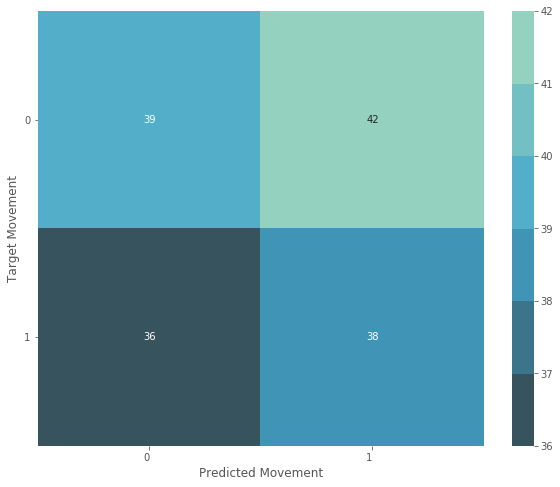

In [18]:
plot_confusion_matrix(test, pred)